In [1]:
import numpy as np
import tensorflow as tf

# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 

import ipysh

%aimport models.base

import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH

%aimport models.AEFIT4
%aimport models.AEFIT5
%aimport models.Compose

# ipysh.Bootstrap_support.debug()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Hunch models imported
reload set for module  Hunch_utils
reload set for module  Dummy_g1data
reload set for module  Hunch_lsplot
reload set for module  Hunch_tSNEplot


# TEST QSH


In [2]:
qsh = Dataset_QSH.Dataset_QSH()
import os
file = ipysh.abs_builddir+'/te_db_r15.npy'
if os.path.isfile(file):
    qsh.load(file)
else:
    qsh.load(ipysh.abs_builddir+'/te_db_2.npy')
    qsh.rebalance_prel(15)
    qsh.save(ipysh.abs_builddir+'/te_db_r15.npy')
    
qsh.shuffle()
qsh.clean_up_poorcurves(5)
qsh.dim = None
qsh.set_null(np.nan)
qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F'])
qsh.unbias_mean(0.5, 'te')
qsh.set_normal_positive(['te'])
qsh.clip_values(0.1,0.6)
qsh.set_normal_positive(['te'])

print("QSH rebalanced 15 points size: ", len(qsh))

QSH rebalanced 15 points size:  47567


In [3]:
Bt_min, Bt_max = np.nanmin(qsh['Bt']), np.nanmax(qsh['Bt'])
def _map(xy,p,Bt):
    # Bt = (Bt-Bt_min)/(Bt_max-Bt_min)
    return (xy,p,Bt),(xy,p,Bt)
# ds = qsh.tf_tuple_compose(['prel','te','tbordo~tcentro~Ip~NS~VT~F','absBt_rm~argBt_rm']).map(lambda x,y,t,s: (_map(x,y,t,s)) )
# ds = qsh.tf_tuple_compose(['prel~te:15','tbordo~tcentro~Ip~NS~VT~F','absBt_rm~argBt_rm']).map(lambda x,y,z: ((x,y,z),(x,y,z)))
ds = qsh.tf_tuple_compose(['prel~te:15','tbordo~tcentro~Ip~NS~VT~F','Bt']).map(lambda x,y,z: _map(x,y,z) )
[x for x in ds.shuffle(100).batch(2).take(1)][0]

W0827 15:38:33.070436 140038506567488 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:504: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


((<tf.Tensor: id=58, shape=(2, 30), dtype=float32, numpy=
  array([[0.02827343, 0.10277789, 0.15121816, 0.20828514, 0.27427357,
          0.3485927 , 0.42948723, 0.51404023, 0.59859335, 0.6794879 ,
          0.75380695, 0.8197954 , 0.8768625 , 0.9253027 , 0.96593666,
          0.4479652 , 0.44344586, 0.45555127, 0.4537953 , 0.5063059 ,
          0.5167111 , 0.5173698 , 0.5186978 , 0.52560556, 0.51645434,
          0.506659  , 0.46800196, 0.49627608, 0.46119475, 0.40441918],
         [0.02827343, 0.10277789, 0.15121816, 0.20828514, 0.27427357,
          0.3485927 , 0.42948723, 0.51404023, 0.59859335, 0.6794879 ,
          0.75380695, 0.8197954 , 0.8768625 ,        nan, 0.96593666,
          0.43686265, 0.44403887, 0.50573033, 0.49210274, 0.5513555 ,
          0.5651434 , 0.527565  , 0.5273857 , 0.5077054 , 0.5078784 ,
          0.4662639 , 0.4378279 , 0.46724635,        nan, 0.31878376]],
        dtype=float32)>, <tf.Tensor: id=59, shape=(2, 6), dtype=float32, numpy=
  array([[0.3852216

In [7]:
m1 = models.AEFIT5.AEFIT5(latent_dim=10, feature_dim=30,  dprate=0., scale=2, geometry=[20,20,10,10], beta=0.) #beta=0.001)
m1.load('step10_qsh_fit5_l10')
m2 = models.AEFIT5.AEFIT5(latent_dim=6, feature_dim=6,  dprate=0., scale=1, beta=0., name='temp', geometry=[]) # parameters
m3 = models.AEFIT5.AEFIT5(latent_dim=20, feature_dim=20,  dprate=0., scale=1, beta=0., name='spectrum', geometry=[]) # spectrum
# m3.compile( loss=tf.keras.losses.mean_squared_error )
# m2i = tf.keras.Sequential([ tf.keras.layers.InputLayer(input_shape=(6,)) ])
# m2i.compile( optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.mean_absolute_error )
hm_feature_dim = m1.latent_dim + m2.latent_dim + m3.latent_dim
hm = models.AEFIT5.AEFIT5(latent_dim=2, feature_dim=hm_feature_dim, beta=0., scale=1, name='hidden', geometry=[20,20,20])
h = models.Compose.Compose().set_model(hm).compose([m1,m2,m3])

AEFIT5 ready:
AEFIT5 ready:
AEFIT5 ready:
AEFIT5 ready:
[(None, 30), (None, 6), (None, 20)]


In [8]:
m1.trainable = False
m2.trainable = False
m3.trainable = False
hm.trainable = True
h.loss_weights = [0.6,0.2,0.2]
h.compile( )

In [9]:
# hm.beta = 1.
# h.compile()
models.base.train_thread(h, ds, epoch=30, batch=100, learning_rate=1e-3, callbacks=[]).control_panel()
# h.fit(ds.batch(100), epochs=6)

Epoch 1/30
475/475 [==============================] - 22s 47ms/step - loss: 22.5625 - output_1_loss: 18.6595 - output_2_loss: 3.8308 - output_3_loss: 0.6638
Epoch 2/30
415/475 [=========================>....] - ETA: 2s - loss: 22.3456 - output_1_loss: 18.5670 - output_2_loss: 3.5462 - output_3_loss: 0.2530

In [ ]:
hm2 = models.AEFIT5.AEFIT5(latent_dim=2, feature_dim=h.latent_dim, beta=0., scale=1, name='hm2', geometry=[10])
h2  = models.Compose.Compose().set_model(hm2).compose([h])
hm2.trainable = True
h.trainable = False
h2.compile( loss=hm2.loss )

models.base.train_thread(h2, ds, epoch=3, batch=100, learning_rate=1e-3, callbacks=[]).control_panel()

In [ ]:
p = Hplt.LSPlotBokeh()
p.set_model(h)
p.set_data(qsh, feed_data=ds, counts=1000)
p.plot(notebook_url='http://172.17.0.2:8888')

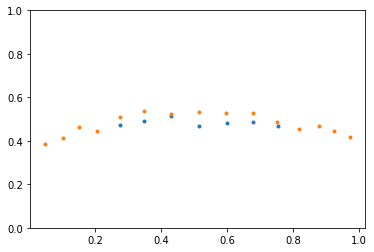

In [10]:
# [ v.name for v in h2.trainable_variables ]
def plot(xy):
    plt.figure('data')
    ax = plt.gca()
    ax.set_ylim(0.,1.)
    x,y = tf.split(xy[0], num_or_size_splits=2)
    plt.plot(x,y,'.')
d = [x for x in ds.shuffle(1000).batch(1).take(100)][0]
d0 = d[0][0]
y0 = h(d[0], training=False)
y0 = tf.sigmoid(y0[0])
plot(d0)
plot(y0)



In [ ]:
# tbordo tcentro Ip NS VT F
xy,_ =  [x for x in ds.batch(1).take(1)][0]
par = xy[2]

l,_ = h.encode(xy, training=False)
XY  = h.decode(l, training=False, apply_sigmoid=True) 
PAR = XY[2]

print( list(zip(par, PAR)) )


In [ ]:
fig = plt.figure('test_curve',figsize=(18, 6))
plt.clf()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)    
# ax1.set_xlim(-2.,2.)
ax2.set_ylim(0.,1.)

# sx = []
# sy = []
# for xy in ds.batch(1).take(1000):
#     xy,_ = xy
#     x,y = tf.split(xy[0],2, axis=1)
#     me,_  = h.encode(xy, training=False)
#     gpt = me[0].numpy()
#     #ax1.scatter(gpt[0],gpt[1])
#     sx.append(gpt[0])
#     sy.append(gpt[1])

# ax1.scatter(sx,sy)
    
for xy in ds.shuffle(100).batch(1).take(1):    
    xy,_ = xy
    x,y = tf.split(xy[0],2, axis=1)
    ax2.scatter(x,y,s=80)
    me,_  = h.encode(xy, training=False)
    gpt = me[0].numpy()
    ax1.scatter(gpt[0],gpt[1])
    
    XY = h.decode(me, training=False)[0]
    XY = tf.sigmoid(XY)
    X,Y = tf.split(XY[0], num_or_size_splits=2)
    X,Y = (X.numpy(), Y.numpy())
    ax2.scatter(X,Y,s=40)

print(qsh_pos)    
qsh_pos += 1

In [ ]:
xy,_ = [x for x in ds.batch(2).take(1)][0]
me,va = h.encode(xy)
XY = h.decode(me, apply_sigmoid=True)
XY[0][0]